### Importing Libraries
For installation of the libraries, you have to run the following commands from a terminal or a powershell window: 
```
pip install imutils
pip install numpy
pip install scikit-image
pip install opencv-python
pip install matplotlib
```

In [1]:
from imutils import contours 
from skimage import measure  
import numpy as np          
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt

%matplotlib inline



In [2]:
def plot_imshow_in_array(matrices_to_show:list , max_image_in_row:int = 4 , plots_kwargs_list:list = []):
    """
        Plots the image list in an array of row * col , where max(col) = max_image_in_row, and the 
        number of rows is calculated accordingly. 
        @param matrices_to_show a list of matrices to be plotted using plt.imshow
        @param max_image_in_row maximum number of plots in one row
        @param plots_kwargs_list list of dictionaries of parameters of each plot
        
    """    
    ## total number of plots
    plot_count = len(matrices_to_show)
    
    assert len(plots_kwargs_list) == 0 or len(plots_kwargs_list) == len(matrices_to_show) , """ plots_kwargs_list should be either an empty 
                                                                                    list or should have the same number of members
                                                                                    as matrices_to_show """
    
    ## number of rows
    nrow = plot_count // max_image_in_row + (1 if (plot_count % max_image_in_row > 0) else 0)
    
    ## number of columns
    ncol = max_image_in_row if plot_count >= max_image_in_row else plot_count
    
    ## plotting using imshow
    fig , ax = plt.subplots(nrow , ncol , figsize = (12 , 6))
    for i in range(plot_count):
        
        ## select the subplot
        plt.subplot(nrow , ncol , i+1 )
        
        ## format the argument dictionary of the imshow function
        if(len(plots_kwargs_list) == 0):
            config_dict = {}
        else: 
            config_dict = plots_kwargs_list[i]
        
        ## pass the image as well as extra arguments to the imshow function
        plt.imshow(matrices_to_show[i] , **config_dict)
        
    return fig , ax 
    

In [3]:
## address of the image to be processed
image_address = "./resources/20220405_180847.jpg"

## test the image address
print(image_address)

./resources/20220405_180847.jpg


### Loading images
Load the image and convert it to grayscale, then make it blurred

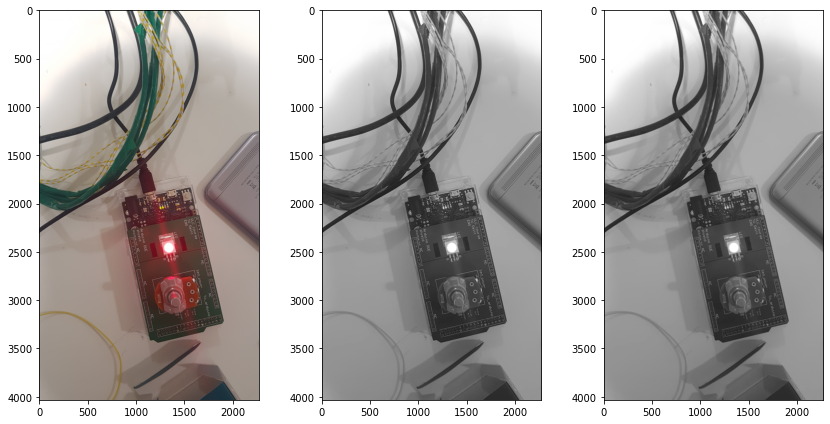

In [4]:
## read the image
image = cv2.imread(image_address)

## convert BGR to RGB, we won't use this in any of the processes, just to test image loading
rgb_image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB) 

## convert BGR to greyscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

## blur the image with a gussian filter to remove any noise, and also to soften the image
blurred = cv2.GaussianBlur(gray, (11, 11), 0)

## plot images in a nice array. We have to define the colormap for imshow to get a black and white image, as the default 
## color map shows colors between yellow (pixel = 255) and black (pixel = 0)
fig , ax = plot_imshow_in_array([rgb_image , gray , blurred] , \
                                max_image_in_row = 4 , \
                                plots_kwargs_list = [{} , {'cmap':'gray', 'vmin':0, 'vmax':255} , {'cmap':'gray', 'vmin':0, 'vmax':255}] )

## use this command to place enough spacing between the borders of images and the numbers
fig.tight_layout()


### Thresholds
Run a threshold on your image to find out where the brightest spot appears. 
The binary threshold function that we use in this example sets any pixel bigger than 250 to 255, and anything below that to 0. It also marks the edge of your bright region with a green line. 

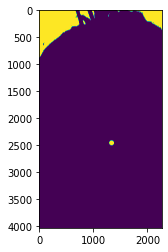

In [5]:
thresh = cv2.threshold(blurred, 250 , 255 , cv2.THRESH_BINARY)[1]
plt.imshow(thresh)
plt.show()

## Remove blobs of noise
In the previous picture, we are likely to come across multiple bright regions. Only one of these is our region of interest (ROI). So, in the first step of finding the ROI, we iterate over the image for a couple of times to remove the very small bright points (which might be due to noise) that exist around larger bright regions. 

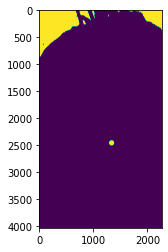

In [6]:
## perform a series of erosions and dilations to remove
## any small blobs of noise from the thresholded image

thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=4)

plt.imshow(thresh)
plt.show()

## Extract contiguous bright islands
We do a connected component analysis, which iterates over the image to find out what regions are contiguious (only one bright island per iteration is found). This block generates a list of "masks", each holding one contiguous region. The regions that contain fewer pixels than a threshold are also ignored. This threshold, as well as your image resolution, determine what the maximum allowed distance from your receiver is. 

(<Figure size 864x432 with 4 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       dtype=object))

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

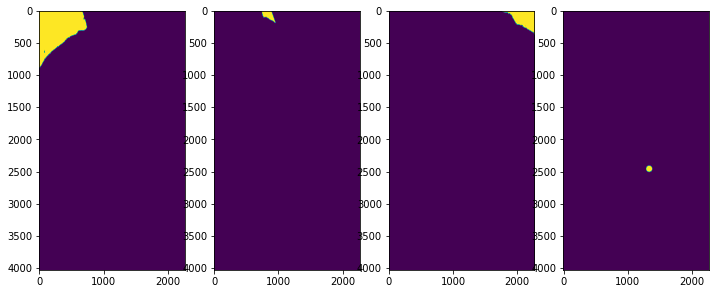

In [7]:
MIN_ALLOWED_PIXEL_IN_REGION = 5000
MAX_GREY_VALUE = 255

## find out regions and label them
labels = measure.label(thresh, connectivity=2, background=0)


## The list holding all contiguous masks that will be found
individual_masks = []

## loop over the unique components
for label in np.unique(labels):
    # if this is the background (dark) label, ignore it
    if label == 0:
        continue
        
    # otherwise, construct the label mask and count the number of pixels 
    labelMask = np.zeros(thresh.shape, dtype="uint8")
    labelMask[labels == label] = MAX_GREY_VALUE
    numPixels = cv2.countNonZero(labelMask)

    
    # this condition filters "very" small regions
    if numPixels > MIN_ALLOWED_PIXEL_IN_REGION:
        plt.figure()        
        individual_masks.append(labelMask)


plot_imshow_in_array(matrices_to_show = individual_masks , max_image_in_row = 4)



### Find out the similarity of the regions to a circle
Based on the shape of our light source, we know that our ROI would be a circle (or it would be better to say the closest shape to a circle is our ROI, as will be seen in the "rolling shutter" assignment). In the following block, we find the smallest circle that encloses each region, calculate its area and find the ratio of the circle that is filled by its inner contiguous region. The ratio which is closer to 1, shows a better match for a cirlce. 

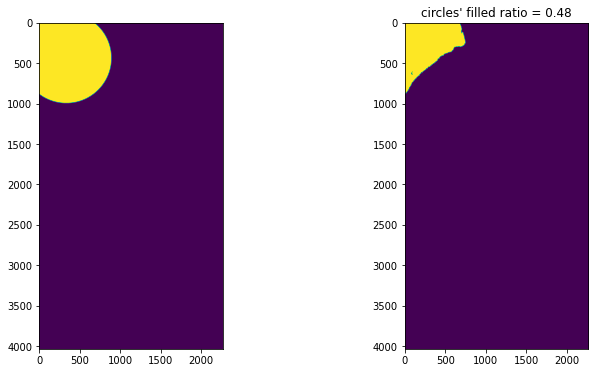

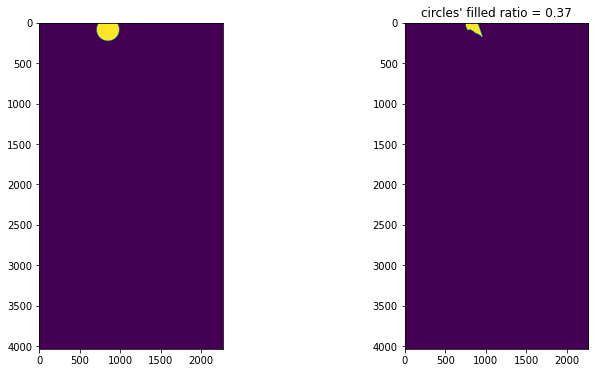

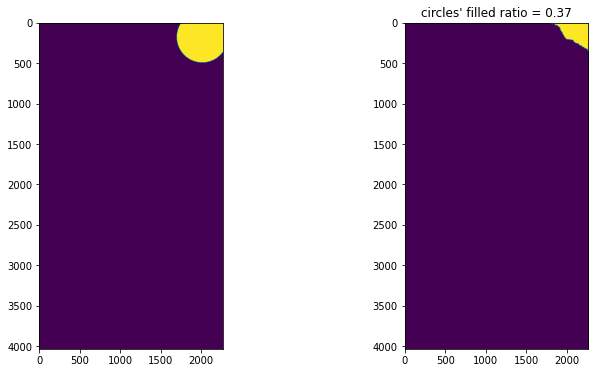

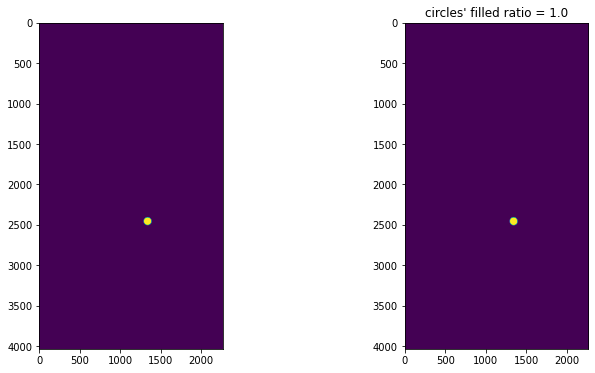

In [8]:
## make a copy of the individual_mask to avoid them from being overwritten
individual_masks_cp = [mask.copy() for mask in individual_masks]

for idx , current_mask in enumerate(individual_masks_cp):
    cnts = cv2.findContours(current_mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
#     cnts = contours.sort_contours(cnts)[0]

    ## create a mask to hold the values of the enclosing circle, we also fill inside the cirlce. 
    filled_circle = np.zeros(current_mask.shape)

    ## find the coordinates of the center and the radius of the circle
    ((cX, cY), radius) = cv2.minEnclosingCircle(cnts[0])
    
    ## fill the mask values surrounded by the circle
    cv2.circle(filled_circle, (int(cX), int(cY)), int(radius),(255, 255, 255), -1)
    
    ## count the number of pixels in the circle
    circle_area = cv2.countNonZero(filled_circle)
    
    ## count the number of non-zero pixels in the original region
    mask_non_zero_area = cv2.countNonZero(individual_masks[idx])
    
    ## plot the circle and the region, and show the filled ratio in each circle
    plot_imshow_in_array([filled_circle , individual_masks[idx]] , max_image_in_row = 4)

    plt.title("circles' filled ratio = {:.2}".format(mask_non_zero_area / circle_area))

## Conclusion
Based on the results above, when the maximum similarity is taken, the last image is determined to be the ROI we are looking for.